# Code for Implementing Facebook's Prophet Model

***

This file implements the Facebook prophet model using the `sktime` interface.

***

# Implement for One Series

***

### Step 1: Import Modules and Data

In [1]:
# general modules
import pandas as pd
import numpy as np

# prophet model
from sktime.forecasting.fbprophet import Prophet

# train-test split function for temporal data
from sktime.forecasting.model_selection import temporal_train_test_split

# performance metrics and plotting
from sktime.performance_metrics.forecasting import mean_absolute_error, mean_squared_error
from sktime.utils.plotting import plot_series

# import transformation functions to create nested dataframes from 2-d arrays and vice-versa
from sktime.datatypes._panel._convert import from_2d_array_to_nested, from_nested_to_2d_array

In [2]:
# import weekly finance time series
Y = np.genfromtxt("../../../Data/Train/Clean/weekly_finance_clean.csv", delimiter = ',', skip_header = 1)

In [3]:
# store the number of series and number of time periods
num_series, num_periods = Y.shape

We apply mean-normalization to all series and take the log. This is to be consistent with pre-processing for machine learning methods.

In [4]:
# calculate the mean value of each series, reshape to column vector
series_means = np.mean(Y, axis=1).reshape(num_series, 1)

In [5]:
# mean normalization and log transform
Y_t = np.log(Y/series_means)

In [6]:
# convert to pandas dataframe to use with sktime functions
Y_t = pd.DataFrame(Y_t)

In [7]:
# store a single series to test code
single_index = 10
y = Y_t.iloc[single_index,:]

In [8]:
# forecasting horizon
fh = np.arange(1, 21)

***

### Step 2: Convert to DateTime Index

Prophet requires a DateTime index, e.g., `'2011-01-01 02:20:00'`, so we must convert the existing series indices to this format.

The `M4-info` data file contains the start date for each series. We can use this and the frequency to contruct the DateTime indices for the series (see example below).

In [9]:
# import M4 info and store the starting data of each series
m4_info = pd.read_csv("../../../Data/M4-info.csv")
start_dates = m4_info.loc[(m4_info.SP == "Weekly") & (m4_info.category == "Finance"), "StartingDate"]

The current index is indicated by an integer value that does not correspond to a specific date.

In [10]:
y

0      0.132217
1      0.138456
2      0.136642
3      0.155708
4      0.151805
         ...   
242   -0.412237
243   -0.410235
244   -0.414202
245   -0.414357
246   -0.431131
Name: 10, Length: 247, dtype: float64

The start date for this series is shown below.

In [11]:
start_dates.iloc[single_index]

'04-07-07 12:00'

We use the `date_range` function to generate the DateTime index for the series using the start date and the frequency (weekly).

In [12]:
new_index = pd.date_range(start=start_dates.iloc[single_index], periods=num_periods, freq="W")
new_index

DatetimeIndex(['2007-04-08 12:00:00', '2007-04-15 12:00:00',
               '2007-04-22 12:00:00', '2007-04-29 12:00:00',
               '2007-05-06 12:00:00', '2007-05-13 12:00:00',
               '2007-05-20 12:00:00', '2007-05-27 12:00:00',
               '2007-06-03 12:00:00', '2007-06-10 12:00:00',
               ...
               '2011-10-23 12:00:00', '2011-10-30 12:00:00',
               '2011-11-06 12:00:00', '2011-11-13 12:00:00',
               '2011-11-20 12:00:00', '2011-11-27 12:00:00',
               '2011-12-04 12:00:00', '2011-12-11 12:00:00',
               '2011-12-18 12:00:00', '2011-12-25 12:00:00'],
              dtype='datetime64[ns]', length=247, freq='W-SUN')

The weekly frequency defaults to ending on Sundays, so the start date is altered slightly. This will be applied consistently to all series - if the start date does not directly correspond to the frequency (Weekly Sundays) then the start date will be adjusted to the next valid timestamp.

**We can revisit this later to force the exact start date and see if this improves forecast accuracy.**

In [13]:
# add the new DateTime index to y
y.index = new_index

In [14]:
# train-test split
y_train, y_test = temporal_train_test_split(y, test_size=len(fh))

***

### Define the Model

In [15]:
forecaster = Prophet()

Some features from [documentation](https://facebook.github.io/prophet/docs/trend_changepoints.html):

* Prophet automatically detects trend changepoints (puts a sparse prior on the magnitudes of rate changes - equivalent to L1 regularization - in a large number of candidate locations - uses as few of them as possible). These are only fit to the beginning 80% of the series in order to project the trend foreward and not overfit any changes at the end of the series.
* You can include holiday effects - `add_country_holidays` method can be used to include default holidays from a specific country.
* Seasonalities - Prophet fits *weekly* and *yearly* seasonalities by default if the series is more than two cycles long. It also fits daily seasonality for a sub-daily series. You can add other seasonalities using the `add_seasonality` method. You can also fit conditional seasonalities (e.g., daily effects that are present on weekends but not during the work week)
* You can specify additional regressors (e.g., weather forecasts as additional regressor for forecasting bike sales)
* Many options allow you to adjust the flexibility or scale of the model component

**Note that since we have weekly data, Prophet will only fit yearly seasonality.**

**We will stick with the default parameters. If we use different data where we have options that can be applied consistently to all series (e.g., holidays) we may change this.**

***

### Fit Model

In [16]:
forecaster.fit(y_train)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Prophet()

### Generate and Evaluate Forecasts

In [17]:
y_pred = forecaster.predict(y_test.index)

0.039692278569134265

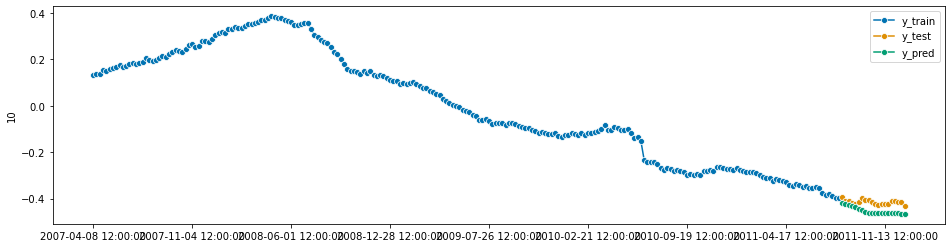

In [18]:
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_error(y_pred, y_test)
mean_squared_error(y_pred, y_test, square_root=True)

***
***

# Implement for All Series

In [19]:
forecaster = Prophet()

In [20]:
# transform to nested dataframe structure
Y_nested = from_2d_array_to_nested(Y_t)

In [21]:
# add DateTime index to every series
for i in range(num_series):
    Y_nested.iloc[i,0].index = pd.date_range(start=start_dates.iloc[i], periods=num_periods, freq="W")

In [22]:
# empty list for forecasts
forecasts = []

for i, series in enumerate(Y_nested.iloc[:,0]):
    
    # train-test split
    y_train, y_test = temporal_train_test_split(series, test_size=len(fh))
    
    # train model
    forecaster.fit(y_train)
    
    # generate forecasts
    y_pred = forecaster.predict(y_test.index)
    
    forecasts.append(y_pred)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to overr

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to overr

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to overr

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to overr

In [23]:
full_forecasts = np.concatenate([np.array(f).reshape(1,len(fh)) for f in forecasts], axis=0)

In [24]:
# extract test data
Train, Test = np.array(Y_t)[:,:-len(fh)], np.array(Y_t)[:,-len(fh):]

In [25]:
# evaluate accuracy metrics
print(mean_absolute_error(full_forecasts.T, Test.T, multioutput='uniform_average'))
print(mean_squared_error(full_forecasts.T, Test.T, multioutput='uniform_average', square_root=True))

0.07248711530328457
0.08093721705359812


In [26]:
def nice_plot(series_index, train_vals=Train, test_vals=Test, preds=full_forecasts, T=num_periods, h=len(fh)):
    """
    Converts training, testing, and forecasted data for a given series,
    then generates a neat plot from the `sktime` package.

    :param series_index: index of the series to plot
    :param train_vals: training data from all series in shape (num_series, num_training_periods)
    :param test_vals: test data from all series in shape (num_series, forecast_horizon)
    :param preds: forecasted values for each series in shape (num_series, forecast_horizon)
    :param T: total number of time periods in train and test data
    :param h: forecast horizon
    :return: nice `sktime` plot
    """
    y_train = pd.Series(train_vals[series_index,:])
    y_test = pd.Series(test_vals[series_index,:], index=np.arange(T-h, T))
    y_pred = pd.Series(preds[series_index,:], index=np.arange(T-h, T))
    
    plot_series(y_train,
                y_test,
                y_pred, 
                labels=["y_train", "y_test", "y_pred"])

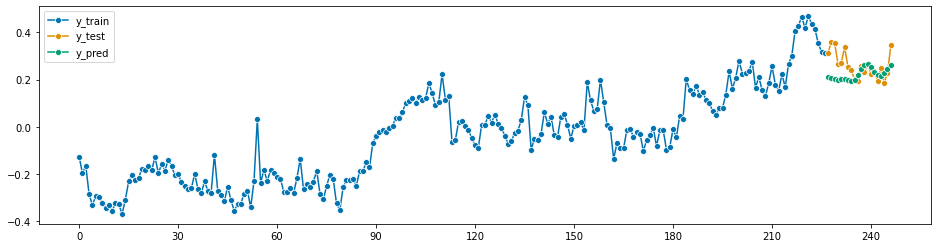

In [27]:
nice_plot(15)

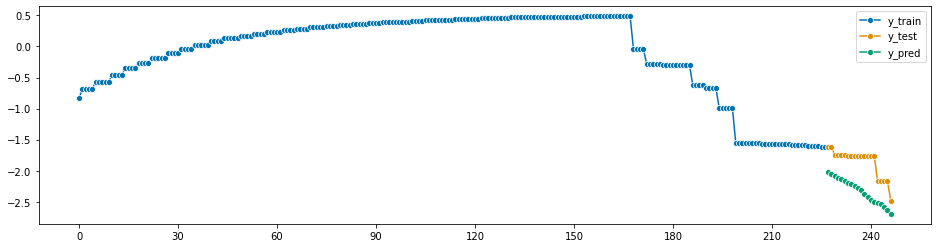

In [28]:
nice_plot(16)

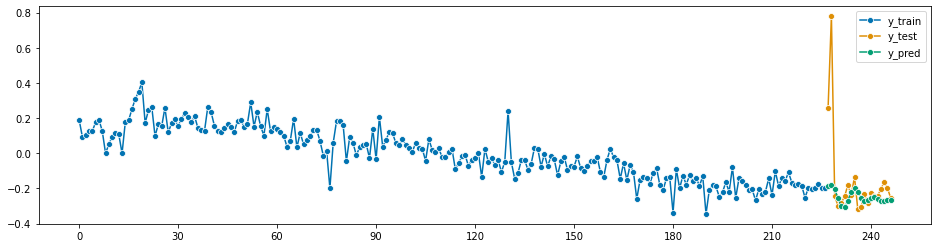

In [29]:
nice_plot(18)

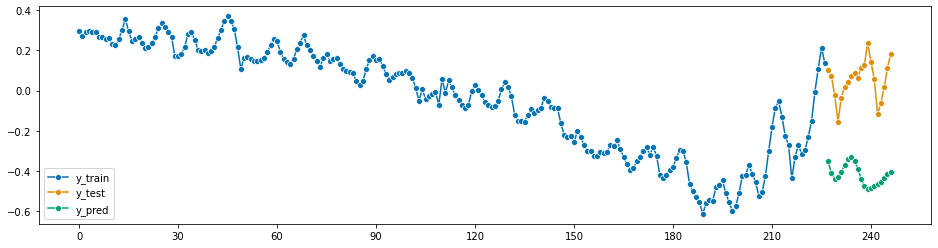

In [30]:
nice_plot(19)

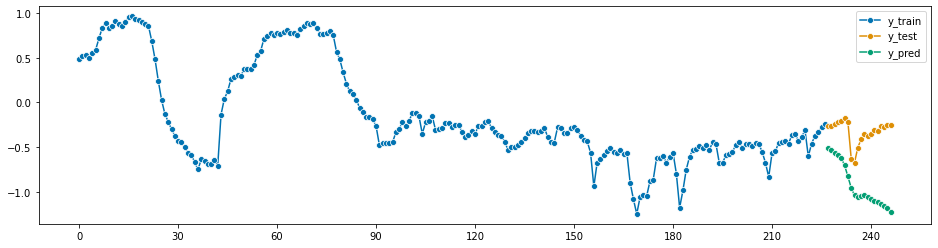

In [31]:
nice_plot(140)

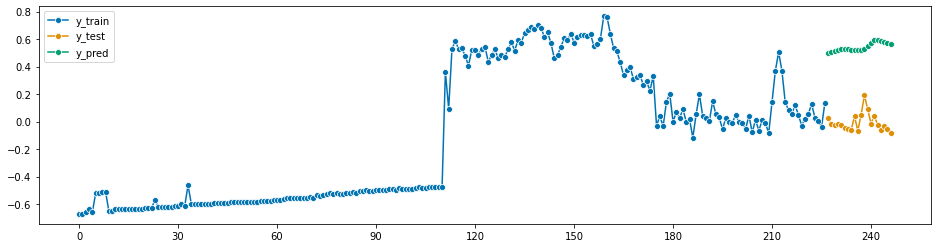

In [32]:
nice_plot(163)